# Solving incompressible heat flow in a cavity

Let us consider the Navier-Stokes equations for the velocity $\mathbf{u}$ and the pressure $p$ of an incompressible fluid

\begin{align*} 
    \nabla \cdot \mathbf{u} &= 0,  \\
    \mathbf{u}_t + \left( \mathbf{u}\cdot\nabla \right)\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathbf{D}(\mathbf{u}) &= 0,
\end{align*}


where  $\mathbf{D}(\mathbf{u}) = \mathrm{sym}(\mathbf{u}) = \frac{1}{2}\left(\nabla \mathbf{u} +  \left( \nabla \mathbf{u} \right)^{\mathrm{T}} \right)$ is the Newtonian fluid's rate of strain tensor and $\mu$ is the viscosity.

# Versions

- Python 3.8
- Pymor 2021
- Dolfin 2019

In [1]:
# ### ROM generation (POD/DEIM)
from pymor.algorithms.ei import ei_greedy
from pymor.algorithms.newton import newton
from pymor.algorithms.pod import pod
from pymor.operators.ei import EmpiricalInterpolatedOperator
from pymor.reductors.basic import InstationaryRBReductor
# ### ROM validation
import time
import numpy as np
# ### pyMOR wrapping
from pymor.bindings.fenics import FenicsVectorSpace, FenicsOperator, FenicsVisualizer, FenicsMatrixOperator
from pymor.models.basic import InstationaryModel
from pymor.operators.constructions import VectorOperator
from pymor.algorithms.timestepping import ImplicitEulerTimeStepper

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# FOM
import dolfin as df
# PLOTS
import matplotlib.pyplot as plt

In [3]:
def plot_w(w, split = False, save = False, outdir = './fig/', name = '', nt = ''):
    
    if (type(nt)!=type('')):
        nt=str(nt)
    
    if split:
        p, u = df.split(w.leaf_node())
    else:
        p, u  = w.split()   
    
    fig = df.plot(u)
    plt.title("Velocity vector field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)  
    if save:
        plt.savefig(outdir+name+'velocity'+nt+'.png')
        del fig
        plt.clf()  
        plt.close() 
    else:
        plt.show()
    
    fig = df.plot(p)
    plt.title("Pressure field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)    
    if save:
        plt.savefig(outdir+name+'pressure'+nt+'.png')
        del fig
        plt.clf()  
        plt.close() 
    else:
        plt.show()

    if 0:
        fig = df.plot(T)
        plt.title("Temperature field")
        plt.xlabel("$x$")
        plt.ylabel("$y$")    
        plt.colorbar(fig)    
        plt.savefig(outdir+name+'temperature'+nt+'.png')
        del fig
        plt.clf()  
        plt.close() 
    #end
    return


In [4]:
def discretize(dim, n, order):
    # ### problem definition

    if dim == 2:
        mesh = df.UnitSquareMesh(n, n)
    else:
        raise NotImplementedError

    P1 = df.FiniteElement('P', mesh.ufl_cell(), 1)
    P2 = df.VectorElement('P', mesh.ufl_cell(), 2, dim = 2)
    # Taylor-Hoods elements
    TH = df.MixedElement([P1, P2])
    W = df.FunctionSpace(mesh, TH)
    
    if 1:
        W_p = W.sub(0)
        W_u = W.sub(1)
    else:
        # mi sa che non va bene perche' i dof di 
        # u e p sono mischiati, quindi w != (p,u)
        # e questo fa si che la matrice non si possa 
        # costruire a blocchi
        W_p = df.FunctionSpace(mesh, P1)
        W_u = df.FunctionSpace(mesh, P2)
    #
    #

    p = df.TrialFunction(W_p)
    u = df.TrialFunction(W_u)
    psi_p = df.TestFunction(W_p)
    psi_u = df.TestFunction(W_u)

    
    MASS1 = df.assemble(df.inner(u, psi_u) * df.dx)
    
    fig=plt.spy(MASS1.array())
    plt.show()
  
    # Test functions
    psi_p, psi_u = df.TestFunctions(W)

    # Solution functions
    w = df.Function(W)
    p, u = df.split(w)

    # Parameters
    Re = df.Constant(1.)

    # velocity BCs
    hot_wall    = "near(x[0],  0.)" #x=0 
    cold_wall   = "near(x[0], 1.)" #x= \bar{x}
    top_wall    = "near(x[1], 1.)" #y=1
    bottom_wall = "near(x[1],  0.)" #y=0
    walls = hot_wall + " | " + cold_wall + " | " + bottom_wall
    
    bcu_noslip  = df.DirichletBC(W_u, df.Constant((0, 0)), walls)
    bcu_lid = df.DirichletBC(W_u, df.Constant((1,0)), top_wall)
    
    # pressure BCs
    pressure_point = "near(x[0],  0.) & (x[1]<= "+str(2./n)+")"
    bcp  = df.DirichletBC(W_p, df.Constant(0), pressure_point)
    
    bc = [bcu_noslip, bcu_lid, bcp]

    # define Fenics model
    mass = -psi_p*df.div(u)
    momentum = (df.dot(psi_u, df.dot(df.grad(u), u)) 
                - df.div(psi_u)*p 
                + 2.*(1./Re)*df.inner(df.sym(df.grad(psi_u)), df.sym(df.grad(u))))
    F = (mass+momentum)*df.dx
    
    # solve Full Order Model
    df.solve(F == 0, w, bc,
             solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})

    plot_w(w)

    # PyMOR binding
    
    # FEM space
    space = FenicsVectorSpace(W)
    # Mass operator
    mass_op = FenicsMatrixOperator(MASS1, W, W, name='mass')
    # Stationary operator
    op = FenicsOperator(F, space, space, w, bc,
                        parameter_setter=lambda mu: Re.assign(mu['Re'].item()),
                        parameters={'Re': 1},
                        solver_options={'inverse': {'type': 'newton', 
                                                    'rtol': 1e-6, 
                                                    'return_residuals': 'True'}})
    

    #time discretization
    nt = 3
    timestep_size = 0.01
    ie_stepper = ImplicitEulerTimeStepper(nt=nt)
    
    # initial conditions
    fom_init = VectorOperator(op.range.zeros()) 
    #rhs
    rhs = VectorOperator(op.range.zeros())
    
    # FOM binding 
    fom = InstationaryModel(timestep_size*nt, # T
                            fom_init, 
                            op, 
                            rhs,
                            mass=mass_op,
                            time_stepper=ie_stepper,
                            visualizer=FenicsVisualizer(space))
    
    return fom, W

In [10]:
def main(n):
    
    """Reduces a FEniCS-based nonlinear diffusion problem using POD/DEIM.
    Input
    - n: Number of mesh intervals per spatial dimension. """
    dim = 2
    order = 2
    
    fom, W = discretize(dim, n, order)

    # define range for parameters
    parameter_space = fom.parameters.space((1., 500.))
   
    # collect snapshots FOM
    U = fom.solution_space.empty()
    residuals = fom.solution_space.empty()
    for mu in parameter_space.sample_uniformly(10):
        #UU, data = newton(fom.operator, fom.rhs.as_vector(), mu=mu, rtol=1e-6, return_residuals=True)
        UU = fom.solve(mu)
        U.append(UU)
        #print(len(UU), UU.dim)
        #residuals.append(data['residuals'])
    #end

    # extract and plot last time step solution
    U_df = df.Function(W)
    U_df.leaf_node().vector()[:] = (U.to_numpy()[-1,:]).squeeze()#.reshape((UU.to_numpy().size,))
    plot_w(U_df, name='fom_')
    
    # build reduced basis
    rb, svals = pod(U, rtol=1e-7)
    reductor = InstationaryRBReductor(fom, rb)
    rom = reductor.reduce()
    # the reductor currently removes all solver_options so we need to add them again
    rom = rom.with_(operator=rom.operator.with_(solver_options=fom.operator.solver_options))

    # ensure that FFC is not called during runtime measurements
    rom.solve(1)

    # validate ROM
    errs = []
    speedups = []
    for mu in parameter_space.sample_randomly(10):
        tic = time.perf_counter()
        U = fom.solve(mu)
        t_fom = time.perf_counter() - tic

        tic = time.perf_counter()
        u_red = rom.solve(mu)
        t_rom = time.perf_counter() - tic

         
        U_red = reductor.reconstruct(u_red)
        diff = U - U_red
        error = np.linalg.norm(diff.to_numpy())/np.linalg.norm(U.to_numpy())
        speedup = t_fom / t_rom
        print('error: ', error, 'speedup: ', speedup)
        errs.append(error)
        speedups.append(speedup)
    #endfor
    U_red = df.Function(W)
    U_red.leaf_node().vector()[:] = (U.to_numpy()[-1,:]).squeeze()#.reshape((UU.to_numpy().size,))
    plot_w(U_red, name='rom_')
    
    
    print(f'Maximum relative ROM error: {max(errs)}')
    print(f'Median of ROM speedup: {np.median(speedups)}')

In [11]:
from dolfin.cpp.parameter import parameters, Parameters
from dolfin.parameter import ffc_default_parameters

if not parameters.has_parameter_set("form_compiler"):
    parameters.add(ffc_default_parameters())

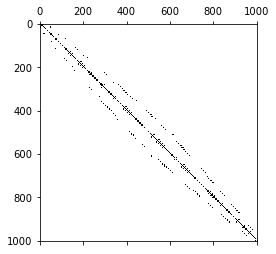

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.144e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 1.915e-02 (tol = 1.000e-10) r (rel) = 1.675e-03 (tol = 1.000e-06)
  Newton iteration 2: r (abs) = 3.215e-07 (tol = 1.000e-10) r (rel) = 2.811e-08 (tol = 1.000e-06)
  Newton solver finished in 2 iterations and 2 linear solver iterations.


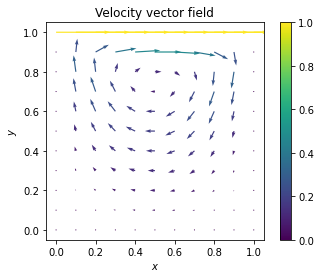

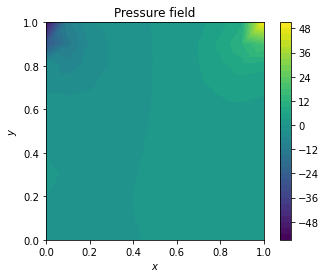

05:10 InstationaryModel: Solving InstationaryModel for {Re: [1.0]} ...
05:10 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:10 |   newton:      norm:0.000e+00                                 res:4.583e-02
05:11 |   newton: it:1 norm:7.744e+01 upd:7.744e+01 rel_upd:1.000e+00 res:9.349e-05 red:2.040e-03 tot_red:2.040e-03
05:11 |   newton: it:2 norm:7.743e+01 upd:2.238e-01 rel_upd:2.890e-03 res:2.483e-10 red:2.656e-06 tot_red:5.418e-09
05:11 |   newton: it:3 norm:7.743e+01 upd:5.361e-07 rel_upd:6.923e-09 res:2.935e-17 red:1.182e-07 tot_red:6.405e-16
05:11 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
05:11 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:11 |   newton:      norm:7.743e+01                                 res:8.336e-03
05:12 |   newton: it:1 norm:8.877e+01 upd:2.101e+01 rel_upd:2.367e-01 res:1.026e-05 red:1.231e-03 tot_red:1.231e-03
05:12 |   newton: it:2 norm:8.877e+01 upd:2.793e-

05:24 |   newton: it:2 norm:4.725e+00 upd:9.752e-04 rel_upd:2.064e-04 res:1.802e-12 red:3.708e-06 tot_red:3.699e-09
05:24 |   newton: it:3 norm:4.725e+00 upd:2.005e-09 rel_upd:4.243e-10 res:1.590e-18 red:8.824e-07 tot_red:3.264e-15
05:24 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
05:24 InstationaryModel: Solving InstationaryModel for {Re: [222.77777777777777]} ...
05:24 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:24 |   newton:      norm:0.000e+00                                 res:4.583e-02
05:25 |   newton: it:1 norm:5.385e+00 upd:5.385e+00 rel_upd:1.000e+00 res:1.975e-05 red:4.310e-04 tot_red:4.310e-04
05:25 |   newton: it:2 norm:5.386e+00 upd:4.599e-02 rel_upd:8.538e-03 res:3.435e-09 red:1.739e-04 tot_red:7.496e-08
05:25 |   newton: it:3 norm:5.386e+00 upd:5.990e-06 rel_upd:1.112e-06 res:8.250e-17 red:2.402e-08 tot_red:1.800e-15
05:26 |   newton: it:4 norm:5.386e+00 upd:1.265e-13 rel_upd:2.349e-14 res:1.85

05:38 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
05:38 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:38 |   newton:      norm:4.860e+00                                 res:3.064e-04
05:38 |   newton: it:1 norm:4.667e+00 upd:1.002e+00 rel_upd:2.146e-01 res:1.452e-07 red:4.740e-04 tot_red:4.740e-04
05:39 |   newton: it:2 norm:4.667e+00 upd:3.274e-04 rel_upd:7.015e-05 res:2.111e-13 red:1.454e-06 tot_red:6.890e-10
05:39 |   newton: it:3 norm:4.667e+00 upd:2.798e-10 rel_upd:5.995e-11 res:1.429e-18 red:6.772e-06 tot_red:4.666e-15
05:39 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
05:39 InstationaryModel: Solving InstationaryModel for {Re: [444.55555555555554]} ...
05:39 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:39 |   newton:      norm:0.000e+00                                 res:4.583e-02
05:39 |   newton: it:1 norm:5.590e+00 upd:5.590e+00 re

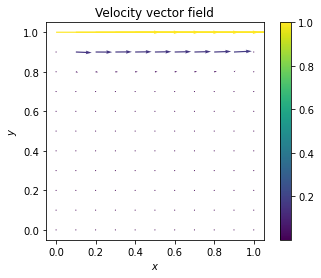

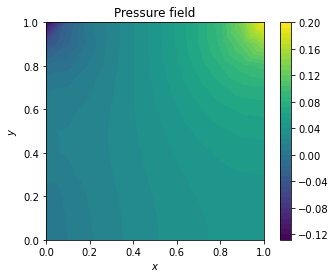

05:47 pod: Computing SVD ...
05:47 |   method_of_snapshots: Computing Gramian (40 vectors) ...
05:47 |   method_of_snapshots: Computing eigenvalue decomposition ...
05:47 |   method_of_snapshots: Computing left-singular vectors (17 vectors) ...
05:47 pod: Checking orthonormality ...
05:47 pod: Reorthogonalizing POD modes ...
05:47 InstationaryRBReductor: Operator projection ...
05:47 |   |WARNING|FenicsOperator: Using inefficient generic projection operator
05:47 InstationaryRBReductor: Building ROM ...
05:47 |WARNING|FixedParameterOperator: Using inefficient generic projection operator
05:47 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:47 |   newton:      norm:0.000e+00                                 res:4.582e-02
05:47 |   newton: it:1 norm:7.759e+01 upd:7.759e+01 rel_upd:1.000e+00 res:2.138e-05 red:4.666e-04 tot_red:4.666e-04
05:47 |   newton: it:2 norm:7.743e+01 upd:2.360e-01 rel_upd:3.049e-03 res:2.542e-11 red:1.189e-06 tot_red:5.547e-10
05:47 |   newt

error:  9.030328131160845 speedup:  24.66432907229995


05:51 |   newton: it:1 norm:5.608e+00 upd:5.608e+00 rel_upd:1.000e+00 res:2.185e-05 red:4.769e-04 tot_red:4.769e-04
05:51 |   newton: it:2 norm:5.609e+00 upd:5.190e-02 rel_upd:9.254e-03 res:5.274e-09 red:2.413e-04 tot_red:1.151e-07
05:51 |   newton: it:3 norm:5.608e+00 upd:9.905e-06 rel_upd:1.766e-06 res:2.454e-16 red:4.653e-08 tot_red:5.355e-15
05:52 |   newton: it:4 norm:5.608e+00 upd:4.709e-13 rel_upd:8.396e-14 res:1.834e-18 red:7.474e-03 tot_red:4.002e-17
05:52 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
05:52 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:52 |   newton:      norm:5.608e+00                                 res:2.719e-03
05:52 |   newton: it:1 norm:4.855e+00 upd:4.714e+00 rel_upd:9.708e-01 res:4.128e-07 red:1.518e-04 tot_red:1.518e-04
05:52 |   newton: it:2 norm:4.855e+00 upd:6.317e-04 rel_upd:1.301e-04 res:1.135e-12 red:2.750e-06 tot_red:4.175e-10
05:53 |   newton: it:3 norm:4.855e+00 upd:2.393e

error:  5.149243720435588e-05 speedup:  29.403012485735925


05:55 |   newton: it:2 norm:5.575e+00 upd:5.102e-02 rel_upd:9.152e-03 res:4.952e-09 red:2.299e-04 tot_red:1.081e-07
05:55 |   newton: it:3 norm:5.575e+00 upd:9.196e-06 rel_upd:1.650e-06 res:2.091e-16 red:4.222e-08 tot_red:4.562e-15
05:55 |   newton: it:4 norm:5.575e+00 upd:3.904e-13 rel_upd:7.002e-14 res:1.647e-18 red:7.879e-03 tot_red:3.594e-17
05:55 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
05:55 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:55 |   newton:      norm:5.575e+00                                 res:2.726e-03
05:56 |   newton: it:1 norm:4.858e+00 upd:4.715e+00 rel_upd:9.706e-01 res:4.540e-07 red:1.666e-04 tot_red:1.666e-04
05:56 |   newton: it:2 norm:4.859e+00 upd:7.127e-04 rel_upd:1.467e-04 res:1.394e-12 red:3.069e-06 tot_red:5.113e-10
05:56 |   newton: it:3 norm:4.859e+00 upd:2.894e-09 rel_upd:5.957e-10 res:2.050e-18 red:1.471e-06 tot_red:7.522e-16
05:56 |   newton: Relative tolerance of 1e-07 fo

error:  2.010067813645906e-05 speedup:  30.328453280493292


05:58 |   newton: it:1 norm:5.041e+00 upd:5.041e+00 rel_upd:1.000e+00 res:1.624e-05 red:3.544e-04 tot_red:3.544e-04
05:58 |   newton: it:2 norm:5.042e+00 upd:3.590e-02 rel_upd:7.121e-03 res:1.584e-09 red:9.756e-05 tot_red:3.458e-08
05:59 |   newton: it:3 norm:5.042e+00 upd:2.461e-06 rel_upd:4.881e-07 res:1.230e-17 red:7.760e-09 tot_red:2.683e-16
05:59 |   newton: it:4 norm:5.042e+00 upd:2.953e-14 rel_upd:5.857e-15 res:1.725e-18 red:1.403e-01 tot_red:3.765e-17
05:59 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
05:59 LincombOperator: Solving nonlinear problem using newton algorithm ...
05:59 |   newton:      norm:5.042e+00                                 res:2.877e-03
05:59 |   newton: it:1 norm:5.082e+00 upd:4.726e+00 rel_upd:9.301e-01 res:1.496e-06 red:5.200e-04 tot_red:5.200e-04
06:00 |   newton: it:2 norm:5.082e+00 upd:2.898e-03 rel_upd:5.703e-04 res:1.227e-11 red:8.200e-06 tot_red:4.264e-09
06:00 |   newton: it:3 norm:5.082e+00 upd:1.753e

error:  0.00024248507427870593 speedup:  27.961399747109372


06:02 |   newton: it:2 norm:4.958e+00 upd:3.304e-02 rel_upd:6.664e-03 res:1.250e-09 red:8.183e-05 tot_red:2.728e-08
06:02 |   newton: it:3 norm:4.958e+00 upd:1.884e-06 rel_upd:3.800e-07 res:6.970e-18 red:5.576e-09 tot_red:1.521e-16
06:03 |   newton: it:4 norm:4.958e+00 upd:6.918e-14 rel_upd:1.395e-14 res:1.620e-18 red:2.325e-01 tot_red:3.536e-17
06:03 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
06:03 LincombOperator: Solving nonlinear problem using newton algorithm ...
06:03 |   newton:      norm:4.958e+00                                 res:2.913e-03
06:03 |   newton: it:1 norm:5.160e+00 upd:4.724e+00 rel_upd:9.155e-01 res:1.744e-06 red:5.987e-04 tot_red:5.987e-04
06:03 |   newton: it:2 norm:5.161e+00 upd:3.394e-03 rel_upd:6.577e-04 res:1.567e-11 red:8.986e-06 tot_red:5.380e-09
06:04 |   newton: it:3 norm:5.161e+00 upd:2.149e-08 rel_upd:4.164e-09 res:1.870e-18 red:1.193e-07 tot_red:6.419e-16
06:04 |   newton: Relative tolerance of 1e-07 fo

error:  0.0010591435459280294 speedup:  25.471318562999414


06:05 |   newton: it:1 norm:4.961e+00 upd:4.961e+00 rel_upd:1.000e+00 res:1.533e-05 red:3.346e-04 tot_red:3.346e-04
06:05 |   newton: it:2 norm:4.962e+00 upd:3.321e-02 rel_upd:6.692e-03 res:1.268e-09 red:8.269e-05 tot_red:2.767e-08
06:06 |   newton: it:3 norm:4.962e+00 upd:1.914e-06 rel_upd:3.857e-07 res:7.255e-18 red:5.722e-09 tot_red:1.583e-16
06:06 |   newton: it:4 norm:4.962e+00 upd:1.244e-14 rel_upd:2.507e-15 res:1.710e-18 red:2.356e-01 tot_red:3.731e-17
06:06 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
06:06 LincombOperator: Solving nonlinear problem using newton algorithm ...
06:06 |   newton:      norm:4.962e+00                                 res:2.910e-03
06:07 |   newton: it:1 norm:5.155e+00 upd:4.725e+00 rel_upd:9.164e-01 res:1.729e-06 red:5.941e-04 tot_red:5.941e-04
06:07 |   newton: it:2 norm:5.156e+00 upd:3.365e-03 rel_upd:6.527e-04 res:1.546e-11 red:8.943e-06 tot_red:5.313e-09
06:07 |   newton: it:3 norm:5.156e+00 upd:2.125e

error:  0.0010013139120267176 speedup:  26.12250019121684


06:09 |   newton: it:1 norm:5.224e+00 upd:5.224e+00 rel_upd:1.000e+00 res:1.817e-05 red:3.965e-04 tot_red:3.965e-04
06:09 |   newton: it:2 norm:5.225e+00 upd:4.149e-02 rel_upd:7.941e-03 res:2.455e-09 red:1.351e-04 tot_red:5.358e-08
06:10 |   newton: it:3 norm:5.225e+00 upd:4.057e-06 rel_upd:7.766e-07 res:3.565e-17 red:1.452e-08 tot_red:7.778e-16
06:10 |   newton: it:4 norm:5.225e+00 upd:4.721e-14 rel_upd:9.036e-15 res:1.878e-18 red:5.270e-02 tot_red:4.099e-17
06:10 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
06:10 LincombOperator: Solving nonlinear problem using newton algorithm ...
06:10 |   newton:      norm:5.225e+00                                 res:2.814e-03
06:10 |   newton: it:1 norm:4.962e+00 upd:4.727e+00 rel_upd:9.527e-01 res:1.048e-06 red:3.726e-04 tot_red:3.726e-04
06:11 |   newton: it:2 norm:4.962e+00 upd:1.982e-03 rel_upd:3.995e-04 res:6.747e-12 red:6.435e-06 tot_red:2.398e-09
06:11 |   newton: it:3 norm:4.962e+00 upd:1.083e

error:  0.00020887343524012483 speedup:  26.929371532371746


06:13 |   newton: it:2 norm:5.445e+00 upd:4.758e-02 rel_upd:8.738e-03 res:3.860e-09 red:1.900e-04 tot_red:8.422e-08
06:13 |   newton: it:3 norm:5.445e+00 upd:6.863e-06 rel_upd:1.260e-06 res:1.110e-16 red:2.876e-08 tot_red:2.422e-15
06:14 |   newton: it:4 norm:5.445e+00 upd:1.772e-13 rel_upd:3.255e-14 res:1.936e-18 red:1.745e-02 tot_red:4.225e-17
06:14 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
06:14 LincombOperator: Solving nonlinear problem using newton algorithm ...
06:14 |   newton:      norm:5.445e+00                                 res:2.755e-03
06:14 |   newton: it:1 norm:4.881e+00 upd:4.721e+00 rel_upd:9.673e-01 res:6.388e-07 red:2.319e-04 tot_red:2.319e-04
06:14 |   newton: it:2 norm:4.881e+00 upd:1.106e-03 rel_upd:2.266e-04 res:2.759e-12 red:4.319e-06 tot_red:1.002e-09
06:15 |   newton: it:3 norm:4.881e+00 upd:5.243e-09 rel_upd:1.074e-09 res:1.866e-18 red:6.764e-07 tot_red:6.775e-16
06:15 |   newton: Relative tolerance of 1e-07 fo

error:  5.829305878697334e-05 speedup:  30.593536727700606


06:16 |   newton: it:1 norm:5.374e+00 upd:5.374e+00 rel_upd:1.000e+00 res:1.965e-05 red:4.288e-04 tot_red:4.288e-04
06:17 |   newton: it:2 norm:5.375e+00 upd:4.569e-02 rel_upd:8.500e-03 res:3.362e-09 red:1.711e-04 tot_red:7.336e-08
06:17 |   newton: it:3 norm:5.375e+00 upd:5.840e-06 rel_upd:1.086e-06 res:7.808e-17 red:2.323e-08 tot_red:1.704e-15
06:17 |   newton: it:4 norm:5.375e+00 upd:1.600e-13 rel_upd:2.976e-14 res:1.749e-18 red:2.240e-02 tot_red:3.817e-17
06:17 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
06:17 LincombOperator: Solving nonlinear problem using newton algorithm ...
06:17 |   newton:      norm:5.375e+00                                 res:2.772e-03
06:18 |   newton: it:1 norm:4.900e+00 upd:4.724e+00 rel_upd:9.640e-01 res:7.551e-07 red:2.724e-04 tot_red:2.724e-04
06:18 |   newton: it:2 norm:4.901e+00 upd:1.359e-03 rel_upd:2.772e-04 res:3.766e-12 red:4.987e-06 tot_red:1.359e-09
06:19 |   newton: it:3 norm:4.901e+00 upd:6.780e

error:  3.9573367574864666e-05 speedup:  28.82632903149591


06:20 |   newton: it:1 norm:5.203e+00 upd:5.203e+00 rel_upd:1.000e+00 res:1.796e-05 red:3.919e-04 tot_red:3.919e-04
06:20 |   newton: it:2 norm:5.204e+00 upd:4.088e-02 rel_upd:7.856e-03 res:2.344e-09 red:1.306e-04 tot_red:5.116e-08
06:21 |   newton: it:3 norm:5.204e+00 upd:3.847e-06 rel_upd:7.393e-07 res:3.160e-17 red:1.348e-08 tot_red:6.896e-16
06:21 |   newton: it:4 norm:5.204e+00 upd:8.759e-14 rel_upd:1.683e-14 res:1.824e-18 red:5.773e-02 tot_red:3.981e-17
06:21 |   newton: Relative tolerance of 1e-07 for norm of update reached. Converged.
      |   
06:21 LincombOperator: Solving nonlinear problem using newton algorithm ...
06:21 |   newton:      norm:5.204e+00                                 res:2.821e-03
06:22 |   newton: it:1 norm:4.972e+00 upd:4.727e+00 rel_upd:9.506e-01 res:1.094e-06 red:3.879e-04 tot_red:3.879e-04
06:22 |   newton: it:2 norm:4.973e+00 upd:2.078e-03 rel_upd:4.178e-04 res:7.263e-12 red:6.638e-06 tot_red:2.575e-09
06:22 |   newton: it:3 norm:4.973e+00 upd:1.148e

error:  0.00021866344321398831 speedup:  29.331005083852528


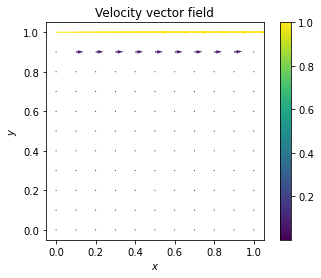

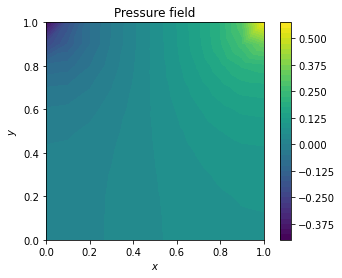

Maximum relative ROM error: 9.030328131160845
Median of ROM speedup: 28.393864389302642


In [12]:
main(10)